# Encoder-Decoder Architecture for Image Caption Generation

## Imports and Setup

In [44]:
import os
import re
import time
import random
import zipfile
import urllib.request
from collections import Counter, defaultdict

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import resnet50
import torchvision.transforms.functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Methods and Classes

Below are the following methods and classes used throughout this pipeline.

### Captions

In [45]:
def normalize_string(s):
  """
  Normalizes a string making it in lowercase, adding a space before puncuation
  and removes any non-letters.

  Args:
      s (str): String to normalize

  Returns:
      str: The normalized string
  """
  s = s.lower().strip()
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  return s


def load_captions(caption_file_path):
  """
  Parses the caption file and stores the list of 5 captions in to defaultdict.

  Args:
      caption_file_path (str): The path to the caption file

  Returns:
      defaultdict: Image file names and respective captions
  """
  captions_dict = defaultdict(list)
  with open(caption_file_path, 'r') as file:
    for line in file:
      line = line.strip()
      if not line:
        continue
      image, caption = line.split('\t')
      image = image.split('#')[0]
      captions_dict[image].append(normalize_string(caption))
  return captions_dict

### Vocab

In [46]:
class Vocab:
  """
  Vocab class to store numerical representations of words with string to index
  and index to string dictionaries.
  """
  def __init__(self, freq):
    """
    Initializes vocabulary with a predetermined number of times a word must
    appear to be added to the vocabulary and special tokens that signify certain
    positions in the sentence.

    Args:
        freq (int): The number of times a word must appear to be added to the
                    vocab

    Returns:
        None
    """
    self.freq = freq

    """
    SPECIAL TOKENS

    PAD: to counter varying lengths in captions
    SOS: start of sentence
    EOS: end of sentence
    UNK: unknown word since using freq
    """
    self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
    self.stoi = {value: key for key, value in self.itos.items()}

  def __len__(self) -> int:
    """
    Returns:
        int: the length of the vocab
    """
    return len(self.itos)

  def tokenize(self, text):
      return text.lower().strip().split()

  def build_vocab(self, captions):
    """
    Builds vocab from a list of captions.

    Args:
        captions (list): List of captions

    Returns:
        None
    """
    counter = Counter()

    # Get a count of tokens present in the captions
    for caption in captions:
      tokens = self.tokenize(caption)
      counter.update(tokens)

    # Add words to vocab if they meet the frequency requirement
    for word, count in counter.items():
      if count >= self.freq:
        i = len(self.stoi)
        self.stoi[word] = i
        self.itos[i] = word

  def numericalize(self, caption):
    """
    Converts a caption into a list of indices.

    Args:
        caption (str): The caption

    Returns:
        list: indices for each token
    """
    tokens = self.tokenize(caption)
    return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]

### Transform

In [47]:
# Transform method to ensure all images are the same size
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], # ResNet means
                                                    std=[0.229, 0.224, 0.225]) # ResNet stds
    ])

### Dataset

In [48]:
class ImageDataset(Dataset):
  """
  This class stored images and their respective numericalized captions for the
  training pipeline.
  """
  def __init__(self, image_dir, captions_dict, vocab, transform, vectors=False):
    """
    Initialize a new Dataset to store images and captions.

    Args:
        image_dir (str): directory of images
        captions_dict (defaultdict[list]): dictionary of lists of captions
        vocab (Vocab): vocabulary derived from the captions
        transform (callable, optional): torchvision transform to apply to an
                                        image
        vectors (bool): True if train dataset and need vectors, false if test and
                    need image paths
    """
    self.image_dir = image_dir
    self.captions_dict = captions_dict
    self.vocab = vocab
    self.transform = transform
    self.vectors = vectors

    self.images = []
    self.captions = []
    for image, captions in captions_dict.items():
      random.shuffle(captions) # random order to avoid learning in fixed order
      for caption in captions:
        self.images.append(image)
        self.captions.append(caption)

  def __len__(self):
    """
    Returns:
        The size of the dataset
    """
    return len(self.captions)

  def __getitem__(self, index):
    """
    Obtains a caption numericalized form and its image at a specified
    index.

    Args:
        index (int): the index

    Returns:
        tuple[torch.Tensor, torch.Tensor]: the image and caption
    """
    # Get image and transform
    image_path = os.path.join(self.image_dir, self.images[index])
    image = Image.open(image_path).convert("RGB")
    if self.transform:
        image = self.transform(image)

    # Get caption and numericalize
    caption = self.captions[index]
    numericalized = [self.vocab.stoi["<SOS>"]]
    numericalized += self.vocab.numericalize(caption)
    numericalized.append(self.vocab.stoi["<EOS>"])

    if self.vectors:
      return image_path, torch.tensor(numericalized)
    else:
      return image, torch.tensor(numericalized)

### Encoder

In [49]:
class ResNetEncoder(nn.Module):
    """
    A ResNet50-Based Encoder for feature exraction from images for caption generation.
    """
    def __init__(self, embed_size):
        """
        Initializes the encoder with ResNet50 and a projection to the desired feature vector size.

        Args:
            embed_size (int): Desired feature vector size

        Returns:
            None
        """
        super(ResNetEncoder, self).__init__()

        resnet = resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]  # remove last fc
        self.encoder = nn.Sequential(*modules)

        # freeze training since pretrained
        for param in self.encoder.parameters():
            param.requires_grad = False

        self.size = 2048
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.size, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)


    def forward(self, images):
        """
        Forward pass through the encoder.

        Args:
            images (torch.Tensor): A batch of images

        Returns:
            torch.Tensor: A batch of image embeddings for the decoder
        """
        with torch.no_grad(): 
            y = self.encoder(images).squeeze()  
        y = self.dropout(y)           
        y = self.fc(y)
        return self.bn(y)

### Decoder

In [50]:
class Decoder(nn.Module):
    """
    A custom LSTM-based decoder for generating captions from image features.
    """
    def __init__(self, input_size, hidden_size, vocab_size, num_layers):
        """
        Initializes the decoder's layers.

        Args:
            input_size (int): Input feature vector size
            hidden_size (int): Number of features in the hidden part of the LSTM
            vocab_size (int): Size of vocab
            num_layers (int): Number of LSTM layers
        """
        super(Decoder, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.init_hidden = nn.Linear(input_size, hidden_size)
        self.init_cell = nn.Linear(input_size, hidden_size)

    def forward(self, features, captions):
        """
        Forward pass through the decoder.

        Args:
            features (torch.Tensor): Image feature vectors
            captions (torch.Tensor): Captions tensor

        Returns:
            Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
                output (torch.Tensor): Tensor containing the predicted vocab logits
                (h_n, c_n) (Tuple[torch.Tensor, torch.Tensor]): Final hidden and cell states from the LSTM.
        """

        embeddings = self.embeddings(captions[:, :-1])
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)

        h_0 = torch.tanh(self.init_hidden(features)).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        c_0 = torch.tanh(self.init_cell(features)).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)   

        outputs, (h_n, c_n) = self.lstm(self.dropout(embeddings), (h_0, c_0))
        return self.fc(outputs), (h_n, c_n)

### Training

In [51]:
def collate_fn(batch):
    """
    Custom collate function for padding varying length captions.

    Args:
        batch (list): List of tuples containig image and caption tensors

    Returns:
        tuple (torch.Tensor, torch.Tensor): image and padded caption
    """
    images, captions = zip(*batch)
    images = torch.stack(images)
    captions = pad_sequence(captions, batch_first=True,
                            padding_value=vocab.stoi["<PAD>"])
    return images, captions

def collate_fn_with_paths(batch):
    """
    Custom collate function for padding varying length captions for test dataset.

    Args:
        batch (list): List of tuples containig image paths and caption tensors

    Returns:
        tuple (str, torch.Tensor): image path and padded caption
    """
    image_paths, captions = zip(*batch)  
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab.stoi["<PAD>"])
    return image_paths, captions

def train(encoder, decoder, dataloader, vocab, epochs, lr):
  """
  Trains an image captioning model using an encoder and decoder architecture.

  Args:
      encoder (Encoder): The CNN-based encoder to extract image features
      decoder (Decoder): The LSTM-based decoder to generate captions
      dataloader (DataLoader): DataLoader providing image and caption batches
      vocab (Vocab): Vocab object containing word mappings
      epochs (int): Number of epochs
      lr (float): Learning rate

  Returns:
      list[float]: List of average training loss per epoch
  """

  # ignore padding
  criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
  optimizer = torch.optim.Adam(list(encoder.parameters()) +
                               list(decoder.parameters()), lr=lr)

  losses = []

  for epoch in range(epochs):
    # set to train mode
    encoder.train()
    decoder.train()
    epoch_loss = 0

    for batch, (images, captions) in enumerate(dataloader):
      images = images.to(device)
      captions = captions.to(device)

      optimizer.zero_grad()

      features = encoder(images)
      logits, temp = decoder(features, captions)
      logits = logits[:, 1:, :]
      loss = criterion(logits.reshape(-1, logits.size(2)),
                       captions[:, 1:].reshape(-1))

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

      if batch % 100 == 0:
        print(f"Epoch {epoch+1}, Batch {batch}/{len(dataloader)}")

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

  if (epoch + 1) % 5 == 0:
      torch.save({
          'encoder_state_dict': encoder.state_dict(),
          'decoder_state_dict': decoder.state_dict(),
      }, f'model_epoch_{epoch + 1}.pth')

  return losses

### Inference

In [52]:
def eval(encoder, decoder, test_loader, vocab, max_len):
    """
    Runs inference on a test dataset using greedy decoding and computes
    reference and prediction captions for evaluation.

    Args:
        encoder (ResNetEncoder): Trained ResNet-50 Encoder
        decoder (Decoder): Trained LSTM-based decoder 
        test_loader (DataLoader): DataLoader providing batches of (image_path, caption)
        vocab (Vocab): Vocab object
        max_len (int): Max number of tokens to generate per caption

    Returns:
        references (list[list[list[str]]]): Tokenized reference captions 
        preds (list[list[str]]): Tokenized captions predicted by the model
        image_tensors (list[torch.Tensor]): Image tensors for detransformation after
    """
    encoder.eval()
    decoder.eval()

    sos_index = vocab.stoi["<SOS>"]
    eos_index = vocab.stoi["<EOS>"]
    pad_index = vocab.stoi["<PAD>"]

    references = []
    preds = []
    image_tensors = []

    with torch.no_grad():
        for images, captions in test_loader:
            # Extract Features
            images = images.to(device)  
            image_tensors.extend([image.cpu() for image in images])
            batch_size = images.size(0)
            features = encoder(images)

            # Initialize decoder state
            h_0 = torch.tanh(decoder.init_hidden(features)).unsqueeze(0).repeat(decoder.lstm.num_layers, 1, 1)
            c_0 = torch.tanh(decoder.init_cell(features)).unsqueeze(0).repeat(decoder.lstm.num_layers, 1, 1)

            inputs = torch.tensor([sos_index] * batch_size, device=device).unsqueeze(1)
            generated = [[] for i in range(batch_size)]

            # Generate one word at a time
            for i in range(max_len):
                embeddings = decoder.embeddings(inputs)
                outputs, (h_0, c_0) = decoder.lstm(embeddings, (h_0, c_0))
                outputs = decoder.fc(outputs.squeeze(1))
                prediction = outputs.argmax(1)

                # Decode
                for i in range(batch_size):
                    if len(generated[i]) == 0 or generated[i][-1] != eos_index:
                        generated[i].append(prediction[i].item())

                inputs = prediction.unsqueeze(1)

            # Convert captions and predictions to tokens
            for i in range(batch_size):
                ref = captions[i].tolist()
                ref_tokens = [vocab.itos[idx] for idx in ref if idx not in {sos_index, eos_index, pad_index}]
                pred_tokens = [vocab.itos[idx] for idx in generated[i] if idx != eos_index]

                references.append([ref_tokens])  
                preds.append(pred_tokens)   

    return references, preds, image_tensors

### Accuracy

In [53]:
def compute_bleu1(references, predictions):
    """
    Computes the BLEU-1 score for generated captions.

    Args:
        references (list[list[list[str]]]): List of reference captions for each image.
        predictions (list[list[str]]): List of predicted caption tokens.

    Returns:
        float: BLEU-1 score 
    """
    smooth = SmoothingFunction().method1
    return corpus_bleu(references, predictions, weights=(1.0, 0, 0, 0), smoothing_function=smooth)

def compute_bleu4(references, predictions):
    """
    Computes the BLEU-4 score for generated captions.

    Args:
        references (list[list[list[str]]]): List of reference captions for each image.
        predictions (list[list[str]]): List of predicted caption tokens.

    Returns:
        float: BLEU-4 score 
    """
    smooth = SmoothingFunction().method4
    return corpus_bleu(references, predictions, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

## Dataset Preprocessing

The dataset to be used for this task is the [Flick8k dataset](https://github.com/goodwillyoga/Flickr8k_dataset). This dataset contains two parts: the images and the captions. The image/captions pairs are loaded into a dictionary and then
into a custom ImageDataset class that stores the tensor representations of the images
and captions. From that ImageDataset class, the data is split into train/test DataLoader objects for the training and inference of the model.

In [54]:
# Download the dataset (uncomment if first run)

"""

urllib.request.urlretrieve(
    "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip",
    "Flickr8k_Dataset.zip")

urllib.request.urlretrieve(
    "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip",
    "Flickr8k_text.zip")

with zipfile.ZipFile("Flickr8k_Dataset.zip", "r") as zip_ref:
    zip_ref.extractall(".")

with zipfile.ZipFile("Flickr8k_text.zip", "r") as zip_ref:
    zip_ref.extractall("Flickr8k_text")
    
"""

'\n\nurllib.request.urlretrieve(\n    "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip",\n    "Flickr8k_Dataset.zip")\n\nurllib.request.urlretrieve(\n    "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip",\n    "Flickr8k_text.zip")\n\nwith zipfile.ZipFile("Flickr8k_Dataset.zip", "r") as zip_ref:\n    zip_ref.extractall(".")\n\nwith zipfile.ZipFile("Flickr8k_text.zip", "r") as zip_ref:\n    zip_ref.extractall("Flickr8k_text")\n    \n'

In [55]:
# Load captions into dictionary
caption_file_path = "Flickr8k_text/Flickr8k.token.txt"
captions_dict = load_captions(caption_file_path)

# There is a bad image with the '.1', remove from dataset
if '2258277193_586949ec62.jpg.1' in captions_dict:
    del captions_dict['2258277193_586949ec62.jpg.1']

print(captions_dict['1000268201_693b08cb0e.jpg'])
print(len(captions_dict.items()))

['a child in a pink dress is climbing up a set of stairs in an entry way .', 'a girl going into a wooden building .', 'a little girl climbing into a wooden playhouse .', 'a little girl climbing the stairs to her playhouse .', 'a little girl in a pink dress going into a wooden cabin .']
8091


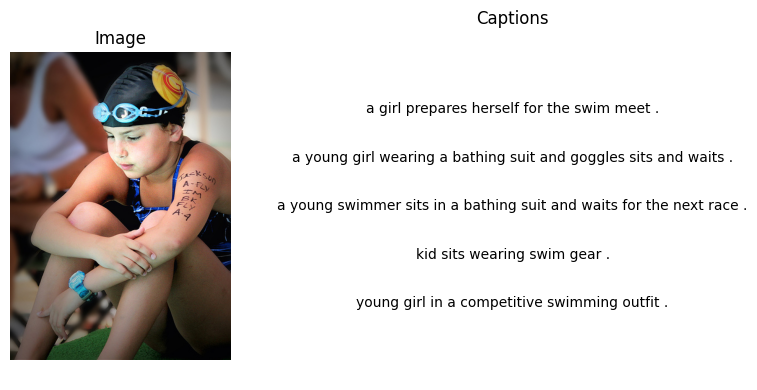

In [56]:
# Display a random image and its captions from the dictionary
random_image = random.choice(list(captions_dict.keys()))
image = mpimg.imread(f'Flicker8k_Dataset/{random_image}')
captions =  captions_dict[random_image]

fig, axs = plt.subplots(1, 2, figsize=(8, 4),
                        gridspec_kw={'width_ratios': [1, 2]})

axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title("Image")

caption = "\n\n\n".join([f"{caption}" for caption in captions])
axs[1].axis('off')
axs[1].text(0.5, 0.5, caption,
            ha='center', va='center',
            wrap=True,
            transform=axs[1].transAxes)
axs[1].set_title("Captions")

plt.tight_layout()
plt.show()

In [57]:
# Build the Vocab from the captions to feed to the decoder
freq = 2

vocab = Vocab(freq)
captions_list = [caption for captions in captions_dict.values() for caption in captions]
vocab.build_vocab(captions_list)

print(f'Number of words: {len(vocab)}')
print(vocab.numericalize(captions_list[500]))
print(captions_list[500].split())

Number of words: 5138
[4, 29, 31, 43, 779, 780, 517, 4, 502, 6, 60, 13, 15, 781, 17]
['a', 'black', 'and', 'white', 'border', 'collie', 'catches', 'a', 'frisbee', 'in', 'front', 'of', 'an', 'audience', '.']


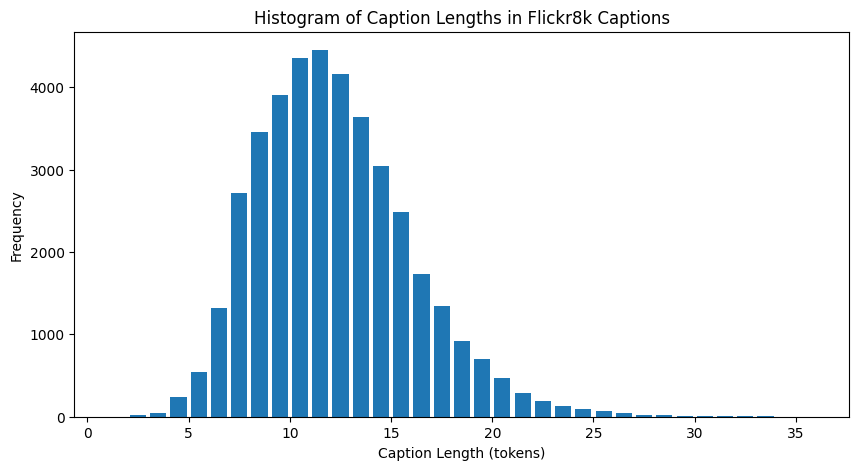

In [58]:
captions_list = [caption for captions in captions_dict.values() for caption in captions]
caption_lengths = [len(vocab.tokenize(caption)) for caption in captions_list]

plt.figure(figsize=(10, 5))
plt.hist(caption_lengths, bins=range(min(caption_lengths), max(caption_lengths)), rwidth=0.8)
plt.xlabel("Caption Length (tokens)")
plt.ylabel("Frequency")
plt.title("Histogram of Caption Lengths in Flickr8k Captions")
plt.show()

In [59]:
# Create dataset of image and caption tensors
dataset = ImageDataset('Flicker8k_Dataset', captions_dict, vocab, transform)
image, caption = dataset[0]
print("Image:", image)
print("Caption:", caption)

Image: tensor([[[-0.7137, -0.2171, -0.1314,  ..., -2.0494, -2.0152, -2.0152],
         [-0.7650, -0.1828, -0.0801,  ..., -1.9809, -1.9980, -1.9124],
         [-0.7993, -0.1143, -0.0458,  ..., -1.9809, -1.9980, -1.9467],
         ...,
         [ 1.0673,  0.4508,  0.8104,  ...,  1.5125,  0.7077,  0.7077],
         [ 0.8961,  0.9132,  1.6495,  ...,  1.4783,  0.7591,  0.7591],
         [ 1.4269,  1.4612,  1.0844,  ...,  1.3927,  0.7419,  0.7762]],

        [[-0.5126,  0.2052,  0.3102,  ..., -1.9832, -1.9307, -1.8957],
         [-0.5651,  0.2227,  0.3803,  ..., -1.8782, -1.8606, -1.6681],
         [-0.6527,  0.2752,  0.4328,  ..., -1.8782, -1.8081, -1.6506],
         ...,
         [-0.1450, -0.6352,  0.1001,  ...,  1.8333,  1.2031,  1.1856],
         [-0.3550,  0.2227,  0.9230,  ...,  1.7808,  1.1856,  1.1856],
         [ 0.1702,  0.5553,  0.1001,  ...,  1.7108,  1.1856,  1.1856]],

        [[-0.1138,  0.3742,  0.4091,  ..., -1.7522, -1.7347, -1.7173],
         [-0.2010,  0.4439,  0.4962,  

In [60]:
# Split dataset into train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

We now have a ready to use dataset to feed to the training pipeline.

## Training
The model is trained here based on the specified parameters. The train function can be found inside the Methods and Classes subsection. A 4-block CNN and LSTM RNN are used for the encoder and decoder respectively. The loss function is the Cross-Entropy Loss Function and the optimizer is the Adam optimizer.

In [16]:
# Training Device Information
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 4060


In [17]:
# params
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)
num_layers = 2
batch_size = 64
epochs = 30
lr = 1e-3

# models
encoder = ResNetEncoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers).to(device)

# data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         collate_fn=collate_fn, pin_memory=True)

# training
losses = train(
    encoder,
    decoder,
    train_loader,
    vocab,
    epochs=epochs,
    lr=lr
)

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Batch 0/506
Epoch 1, Batch 100/506
Epoch 1, Batch 200/506
Epoch 1, Batch 300/506
Epoch 1, Batch 400/506
Epoch 1, Batch 500/506
Epoch [1/30], Loss: 3.8915
Epoch 2, Batch 0/506
Epoch 2, Batch 100/506
Epoch 2, Batch 200/506
Epoch 2, Batch 300/506
Epoch 2, Batch 400/506
Epoch 2, Batch 500/506
Epoch [2/30], Loss: 3.0220
Epoch 3, Batch 0/506
Epoch 3, Batch 100/506
Epoch 3, Batch 200/506
Epoch 3, Batch 300/506
Epoch 3, Batch 400/506
Epoch 3, Batch 500/506
Epoch [3/30], Loss: 2.7440
Epoch 4, Batch 0/506
Epoch 4, Batch 100/506
Epoch 4, Batch 200/506
Epoch 4, Batch 300/506
Epoch 4, Batch 400/506
Epoch 4, Batch 500/506
Epoch [4/30], Loss: 2.5661
Epoch 5, Batch 0/506
Epoch 5, Batch 100/506
Epoch 5, Batch 200/506
Epoch 5, Batch 300/506
Epoch 5, Batch 400/506
Epoch 5, Batch 500/506
Epoch [5/30], Loss: 2.4278
Epoch 6, Batch 0/506
Epoch 6, Batch 100/506
Epoch 6, Batch 200/506
Epoch 6, Batch 300/506
Epoch 6, Batch 400/506
Epoch 6, Batch 500/506
Epoch [6/30], Loss: 2.3105
Epoch 7, Batch 0/506
E

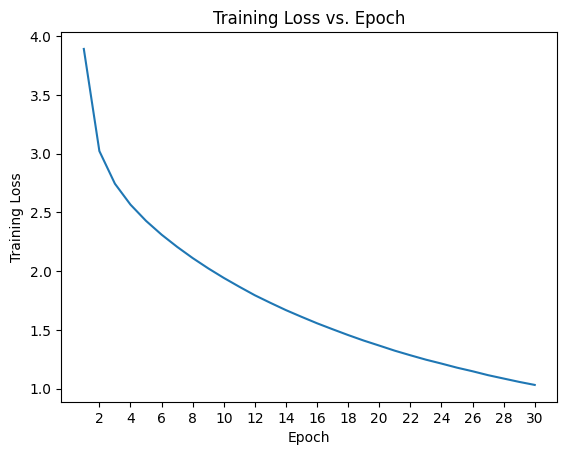

In [23]:
epochs = [x+1 for x in range(len(losses))]

plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.xticks(epochs[1::2])
plt.title("Training Loss vs. Epoch")
plt.show()

After around 93 minutes of training, we trained a model with a loss of 1.0311 at Epoch 30.

## Inference

With the trained model, we can now perform inference and assess accuracy metrics like BLEU and METEOR.

In [61]:
# params
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)
num_layers = 2
batch_size = 64
epochs = 20
lr = 1e-3


# models
encoder = ResNetEncoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers).to(device)

# reload
checkpoint = torch.load('model_epoch_30.pth', map_location=device)
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         collate_fn=collate_fn, pin_memory=True)

references, preds, image_tensors = eval(encoder, decoder, test_loader, vocab, max_len=25)

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
bleu1 = compute_bleu1(references, preds)
bleu4 = compute_bleu4(references, preds)

print(bleu1)
print(bleu4)

0.27686607672157043
0.05744790149846965


After running inference, we obtain a BLEU-1 score of 0.2769 and BLEU-4 of 0.0574.

In [63]:
smooth1 = SmoothingFunction().method1

bleu1_scores = []
for ref, pred, image in zip(references, preds, image_tensors):
    score = sentence_bleu(ref, pred, smoothing_function=smooth1, weights=(1, 0, 0, 0))
    bleu1_scores.append((score, ref[0], pred, image)) 

bleu1_scores.sort(key=lambda x: x[0], reverse=True)
bleu1_scores[0]

(0.9444444444444444,
 ['two',
  'small',
  'children',
  'pop',
  'their',
  'heads',
  'out',
  'of',
  'the',
  'trunk',
  'of',
  'a',
  'car',
  'in',
  'cold',
  'weather',
  '.'],
 ['coloring',
  'two',
  'small',
  'children',
  'pop',
  'their',
  'heads',
  'out',
  'of',
  'the',
  'trunk',
  'of',
  'a',
  'car',
  'in',
  'cold',
  'weather',
  '.'],
 tensor([[[0.6049, 0.6734, 0.4851,  ..., 0.7591, 0.8104, 0.8447],
          [0.9132, 0.9646, 0.8618,  ..., 0.7419, 0.7762, 0.7933],
          [1.0502, 1.1015, 0.9988,  ..., 0.7419, 0.7591, 0.7933],
          ...,
          [1.1872, 0.7248, 1.9407,  ..., 2.2489, 2.2489, 2.2489],
          [1.1529, 0.7762, 1.9407,  ..., 2.2489, 2.2489, 2.2489],
          [1.0673, 0.7762, 1.9578,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[1.0105, 1.0980, 0.8704,  ..., 0.8880, 0.9405, 0.9580],
          [1.3431, 1.3606, 1.2906,  ..., 0.8704, 0.9055, 0.9055],
          [1.3606, 1.3431, 1.3081,  ..., 0.8704, 0.8880, 0.9055],
          ...,
        

This is the caption with the highest BLEU-1 score. Lets get its respective image and plot it

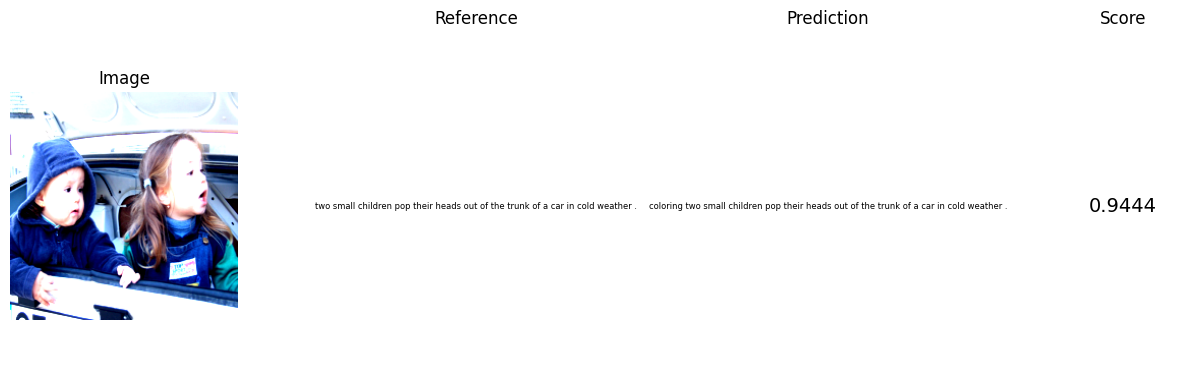

In [68]:
def untransform(img):
    """
    Undo the transformation.
    """
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return (img * std + mean).clamp(0, 1)

best = bleu1_scores[0]

image = TF.to_pil_image(untransform(best[3]))

fig, axs = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1, 1, 0.5]})

# image
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title("Image")

# ref
axs[1].axis("off")
axs[1].text(0.5, 0.5, " ".join(best[1]),
            ha='center', va='center', wrap=True, fontsize=6,
            transform=axs[1].transAxes)
axs[1].set_title("Reference")

# pred
axs[2].axis("off")
axs[2].text(0.5, 0.5, " ".join(best[2]),
            ha='center', va='center', wrap=True, fontsize=6,
            transform=axs[2].transAxes)
axs[2].set_title("Prediction")

# score
axs[3].axis("off")
axs[3].text(0.5, 0.5, f"{best[0]:.4f}",
            ha='center', va='center', fontsize=14,
            transform=axs[3].transAxes)
axs[3].set_title("Score")

plt.tight_layout()
plt.show()

Example of poorly generated caption

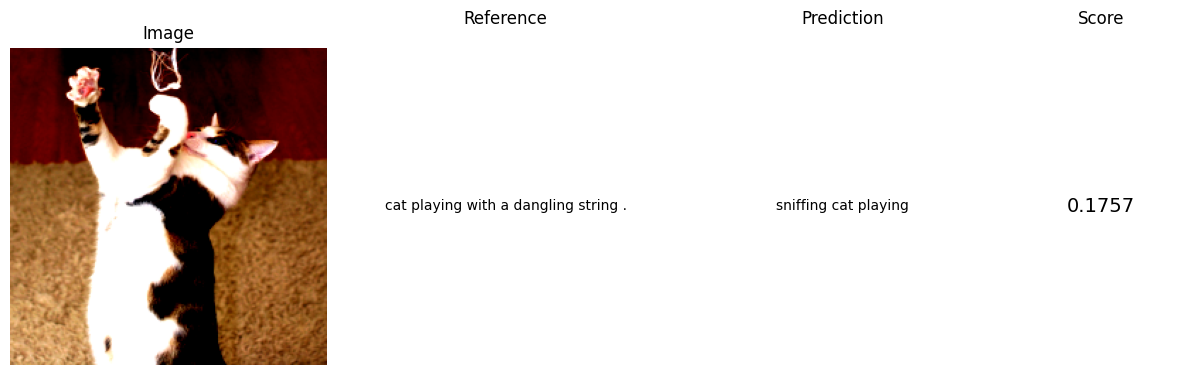

In [93]:
poor = [x for x in bleu1_scores if 0.15 <= x[0] <= 0.35]

example = random.choice(poor)

image = TF.to_pil_image(untransform(example[3]))

fig, axs = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1, 1, 0.5]})

# image
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title("Image")

# ref
axs[1].axis("off")
axs[1].text(0.5, 0.5, " ".join(example[1]),
            ha='center', va='center', wrap=True, fontsize=10,
            transform=axs[1].transAxes)
axs[1].set_title("Reference")

# pred
axs[2].axis("off")
axs[2].text(0.5, 0.5, " ".join(example[2]),
            ha='center', va='center', wrap=True, fontsize=10,
            transform=axs[2].transAxes)
axs[2].set_title("Prediction")

# score
axs[3].axis("off")
axs[3].text(0.5, 0.5, f"{example[0]:.4f}",
            ha='center', va='center', fontsize=14,
            transform=axs[3].transAxes)
axs[3].set_title("Score")

plt.tight_layout()
plt.show()

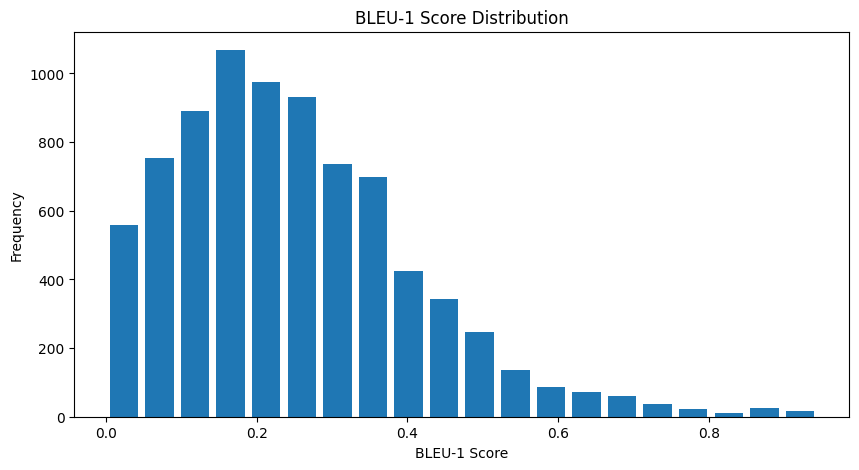

In [94]:
scores = [x[0] for x in bleu1_scores]

plt.figure(figsize=(10, 5))
plt.hist(scores, bins=20, rwidth=0.8)
plt.title("BLEU-1 Score Distribution")
plt.xlabel("BLEU-1 Score")
plt.ylabel("Frequency")
plt.show()